In [1]:
import numpy as np
import pandas as pd

In [2]:
# Read in the two datasets, separate by comma so it looks more like a csv than a txt
salary_data = pd.read_csv("data/2025_salaries.csv")
stats_data = pd.read_csv("data/nba_2025.txt", sep=",")

salary_data.head()
stats_data.head()   

,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,TRB,AST,STL,BLK,TOV,PF,PTS,Trp-Dbl,Awards,Player-additional
0,1.0,Shai Gilgeous-Alexander,27.0,OKC,PG,49.0,49.0,1632.0,534.0,964.0,...,218.0,314.0,64.0,38.0,103.0,101.0,1558.0,0.0,NaN,gilgesh01
1,2.0,Tyrese Maxey,25.0,PHI,PG,52.0,52.0,2008.0,524.0,1117.0,...,214.0,351.0,102.0,40.0,126.0,118.0,1503.0,0.0,NaN,maxeyty01
2,3.0,Donovan Mitchell,29.0,CLE,SG,51.0,51.0,1719.0,516.0,1060.0,...,229.0,302.0,79.0,15.0,159.0,125.0,1478.0,0.0,NaN,mitchdo01
3,4.0,Jaylen Brown,29.0,BOS,SF,49.0,49.0,1676.0,534.0,1105.0,...,336.0,229.0,49.0,20.0,176.0,136.0,1435.0,2.0,NaN,brownja02
4,5.0,Luka Dončić,26.0,LAL,PG,42.0,42.0,1492.0,437.0,923.0,...,329.0,360.0,61.0,19.0,179.0,102.0,1379.0,6.0,NaN,doncilu01


In [3]:
# Fix the names to get rid of extra spaces/characters for ppl like luka doncic and get rid of rows with no player name
stats_data["Player"] = stats_data["Player"].astype(str).str.strip()
stats_data = stats_data.dropna(subset=["Player"])
stats_data["Player"] = stats_data["Player"].str.encode("ascii","ignore").str.decode("ascii")

# For duplicate players, keep only the row where they played the most games. Make the games plated numeric
stats_data["G"] = pd.to_numeric(stats_data["G"], errors="coerce")
stats_data = stats_data.sort_values(["Player", "G"], ascending=[True, False])
stats_data = stats_data.drop_duplicates(subset=["Player"], keep="first").reset_index(drop=True)
stats_data.head()

,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,TRB,AST,STL,BLK,TOV,PF,PTS,Trp-Dbl,Awards,Player-additional
0,142.0,A.J. Green,26.0,MIL,SG,49.0,49.0,1480.0,172.0,391.0,...,128.0,99.0,27.0,5.0,41.0,115.0,522.0,0.0,NaN,greenaj01
1,427.0,A.J. Lawson,25.0,TOR,SG,13.0,0.0,109.0,16.0,41.0,...,23.0,3.0,4.0,3.0,4.0,15.0,49.0,0.0,NaN,lawsoaj01
2,404.0,AJ Johnson,21.0,2TM,SG,28.0,0.0,225.0,27.0,88.0,...,32.0,23.0,7.0,0.0,18.0,15.0,70.0,0.0,NaN,johnsaj01
3,193.0,Aaron Gordon,30.0,DEN,PF,23.0,20.0,642.0,139.0,273.0,...,142.0,58.0,16.0,4.0,24.0,38.0,406.0,0.0,NaN,gordoaa01
4,304.0,Aaron Holiday,29.0,HOU,PG,35.0,1.0,465.0,65.0,161.0,...,30.0,34.0,16.0,4.0,21.0,47.0,200.0,0.0,NaN,holidaa01


In [4]:
# Rename the columns to what they actually should be called
salary_data = salary_data.rename(columns={"Unnamed: 0": "Player", "Unnamed: 1": "Tm", "Salary": "Salary"})

# Drop the first row with the weird header words
salary_data = salary_data.iloc[1:].reset_index(drop=True)
salary_data = salary_data.drop_duplicates(subset=["Player"])
salary_data.head()

,Player,Tm,Salary
0,Jaden Springer,NOP,"$70,732"
1,Garrison Mathews,IND,"$131,970"
3,Mac McClung,IND,"$164,060"
4,Didi Louzada,POR,"$268,032"
5,Monte Morris,IND,"$321,184"


In [5]:
# Make sure everything in the player columns is a string and get rid of the other wierd characters
salary_data["Player"] = salary_data["Player"].astype(str).str.strip()
stats_data["Player"] = stats_data["Player"].astype(str).str.strip()

# Convert the salary amount into dollars and get rid of the commas. Turn it into a float
salary_data["Salary"] = (salary_data["Salary"].astype(str).str.replace(r"[\$,]", "", regex=True).replace("nan", np.nan).astype(float))

# Combine the two datasets into one dataframe
nba_lab = pd.merge(stats_data, salary_data[["Player", "Salary"]], on="Player", how="inner")

nba_lab.shape, nba_lab[["Player","Team","G","Salary"]].head()

((414, 34),
           Player Team     G      Salary
 0     A.J. Green  MIL  49.0   2301587.0
 1     AJ Johnson  2TM  28.0   3090480.0
 2   Aaron Gordon  DEN  23.0  22841455.0
 3  Aaron Holiday  HOU  35.0   2296274.0
 4  Aaron Nesmith  IND  32.0  11000000.0)

In [ ]:
# Okay, now time to actually get into the fun stuff
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# I am going to narrow it down to only the stats that I think are most important
stats = nba_lab[[ 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'GS', 'MP']]

# We have to scale the stats to make them similarly important to each other, because the range of stats is different for each
scaler = StandardScaler()
scaled_stats = scaler.fit_transform(stats)

# Running the kmeans with only 4 clusters to begin
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
nba_lab['Cluster'] = kmeans.fit_predict(scaled_stats)

# Silhouette score checks how separated the clusters are. Higher is better.
score = silhouette_score(scaled_stats, nba_lab['Cluster'])
print(score)

0.3724514268188783


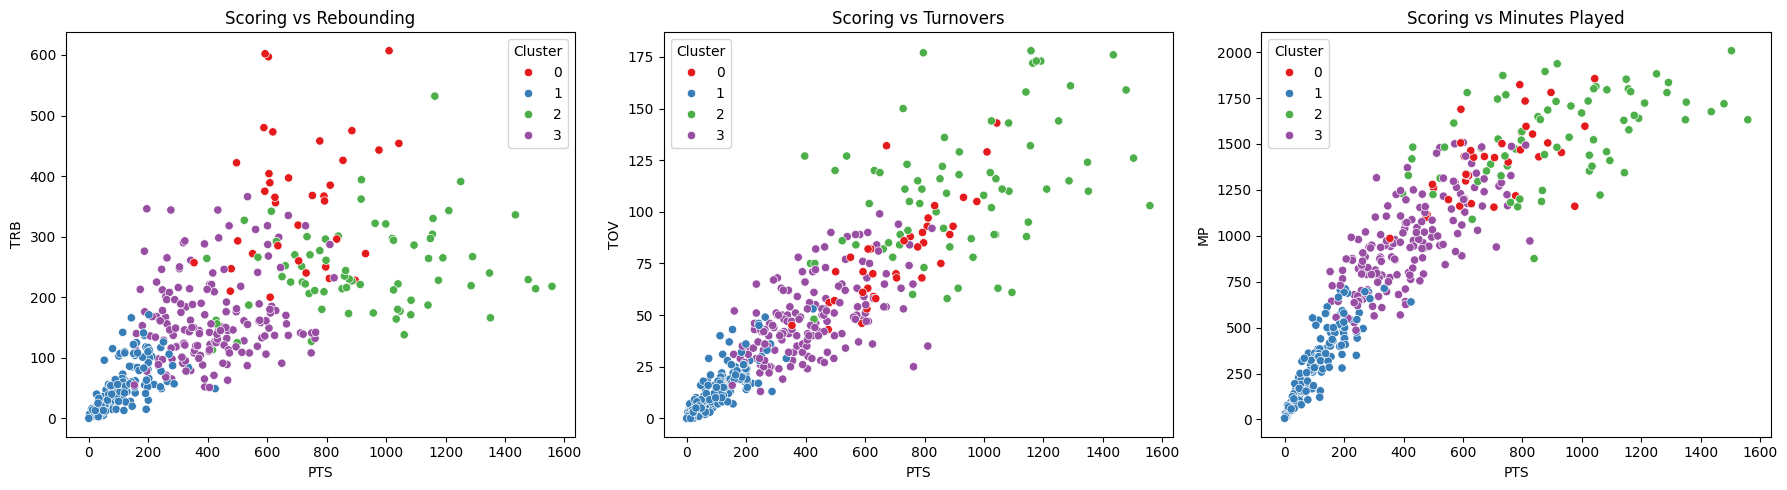

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Now it is time to actually view the results and see how we did with the clustering

fig, axes = plt.subplots(1, 3, figsize=(18,5))

# Plot #1
# Let's compare two features that separates the pure scorers from the players who can rebound. We want players who create more possessions with rebounds
sns.scatterplot(data=nba_lab, x="PTS", y="TRB", hue="Cluster", palette="Set1", ax=axes[0])
axes[0].set_title("Scoring vs Rebounding")

# Plot #2
# Now let's see of the scorers, which of them make a lot of mistakes. We want players that play cleanly and don't turn it over a lot. We want to maximize possesions
sns.scatterplot(data=nba_lab, x="PTS", y="TOV", hue="Cluster", palette="Set1", ax=axes[1])
axes[1].set_title("Scoring vs Turnovers")

# Plot 3
# Now let's see the most efficient scorers. The ones that may not necessarily get a lot of minutes, but score when they do,
sns.scatterplot(data=nba_lab, x="PTS", y="MP",hue="Cluster", palette="Set1", ax=axes[2])
axes[2].set_title("Scoring vs Minutes Played")

plt.tight_layout()
plt.show()

After doing this I'm realizing that the players who are better scorers likely play more minutes and turn the ball over less than players who aren't as good scorers. Hm. This is pretty interesting though. There are several players in the first chart who are in cluster 1 who are incredibly rebounders but don't score as much. These players would likely be aquireable for cheaper salaries. That is definitely something I want to remember and come back to at some point

In [8]:
#Evaluate the quality of the clustering using total variance explained and silhouette scores

# Silhouette score that we took before:
score = silhouette_score(scaled_stats, nba_lab['Cluster'])
print("Score:", score)

# Now lets get the sum of Squares, the first step in getting the variance explained
overall_mean = np.mean(scaled_stats, axis=0)
tss = np.sum((scaled_stats - overall_mean)**2)

# And now the within-cluster sum of squares to help us calculate the variance explained
wcss = kmeans.inertia_

# And here's the variance explained 
v_explained = 1 - (wcss / tss)

print("V explained:", v_explained)

Score: 0.3724514268188783
V explained: 0.7059184478670175


These numbers tell us that the clusters have some good structure, they are decently spread out but they tend to overlap a bit. After doing some research online I found that this is pretty normal, so it isn't something I should necessarily be concerned about. The variance explained basically tells us how much of the total spread of data is reduced by the clustering, and our score of 0.7 is pretty good. It shows that the spread of the data has been decreased by the clustering 

In [9]:
# Okay, now I need to determine the ideal number of clusters to use by using the elbow method and the silhouette coefficient.

# Creating a for-loop for testing K values to identify how many clusters we should use
for k in [2, 3, 4, 5]:
    model = KMeans(n_clusters=k, random_state=42)
    label = model.fit_predict(scaled_stats)
    inertia = model.inertia_
    silhouette = silhouette_score(scaled_stats, label)


    print("# of clusters:", k, ", amount of inertia:", inertia,", and the silhouette score:", silhouette)

# of clusters: 2 , amount of inertia: 1613.119330126821 , and the silhouette score: 0.44320183405182706
# of clusters: 3 , amount of inertia: 1180.1236567303617 , and the silhouette score: 0.36274265921710863
# of clusters: 4 , amount of inertia: 978.7396591021028 , and the silhouette score: 0.3656778906348236
# of clusters: 5 , amount of inertia: 856.9863344570342 , and the silhouette score: 0.321021075173521


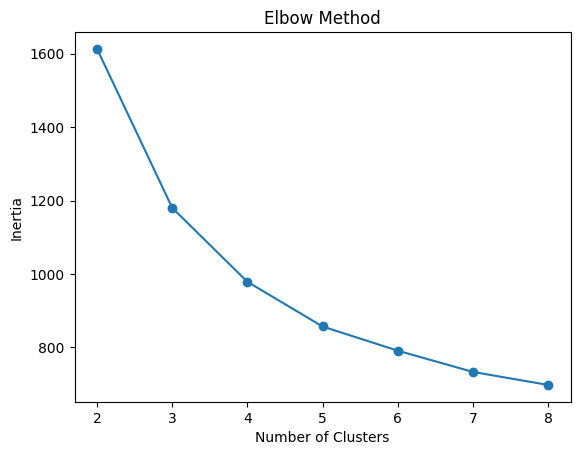

In [15]:
# Now let's get the elbow method chart to visualize our results

inertia = []
k_values = range(2,9)

for k in k_values:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(scaled_stats)
    inertia.append(model.inertia_)

plt.plot(k_values, inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

After looking at the data we got from the different clusters, and viewing the elbow chart it looks like I should use 4 clusters for my project. 4 clusters has low inertia which means that the clusters are tighter, and it has a higher silhouette which means that the clusters are more separate from each other which is good. I'm going to go with 4 clusters

The instructions say to now use the recommended number of clusters to retrain my mode, but I don't need to because I began with 4 clusters and am going to stay at 4 clusters.

In [11]:
# I believe this is the exact same thing as I already did previously, but the instructions say to do it once again, so here we are

# Silhouette score again:
score = silhouette_score(scaled_stats, nba_lab['Cluster'])
print("Score:", score)

# Now lets get the sum of Squares again, the first step in getting the variance explained
overall_mean = np.mean(scaled_stats, axis=0)
tss = np.sum((scaled_stats - overall_mean)**2)

# And now lets get the within-cluster sum of squares again, to help us calculate the variance explained
wcss = kmeans.inertia_

# And here's the variance explained 
v_explained = 1 - (wcss / tss)

print("V explained:", v_explained)

Score: 0.3724514268188783
V explained: 0.7059184478670175


Oh what'd ya know. It's the same as before. I think that that silhouette score is very good, and the variance explained shows that we're on the right track

In [12]:
# Now it is time to use the model to select players for Mr. Rooney to consider

# Let's figure out what the average player salary is per cluster
nba_lab["Cluster_Avg_Salary"] = nba_lab.groupby("Cluster")["Salary"].transform("mean")

# Now let's compare each player's salary to the average salary for each cluster. If this value is negative, the player is someone Mr. Rooney should be interested in as theyare cheaper than people of similar skill.
nba_lab["Salary_Difference"] = nba_lab["Salary"] - nba_lab["Cluster_Avg_Salary"]

# Now let's see who the 8 best players are, in regard to how much cheaper they are than other players at similar skills
nba_lab.sort_values("Salary_Difference").head(12)

,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,TOV,PF,PTS,Trp-Dbl,Awards,Player-additional,Salary,Cluster,Cluster_Avg_Salary,Salary_Difference
379,78.0,Toumani Camara,25.0,POR,PF,56.0,56.0,1873.0,261.0,592.0,...,111.0,178.0,734.0,0.0,NaN,camarto01,2221677.0,2,2.456610e+07,-2.234442e+07
75,83.0,Collin Gillespie,26.0,PHO,PG,54.0,35.0,1527.0,250.0,576.0,...,89.0,83.0,718.0,0.0,NaN,gilleco01,2296274.0,2,2.456610e+07,-2.226982e+07
348,62.0,Russell Westbrook,37.0,SAC,SF,52.0,46.0,1521.0,294.0,683.0,...,177.0,128.0,796.0,4.0,NaN,westbru01,2296274.0,2,2.456610e+07,-2.226982e+07
148,148.0,Isaiah Collier,21.0,UTA,PG,48.0,12.0,1225.0,186.0,365.0,...,120.0,115.0,499.0,0.0,NaN,colliis01,2638200.0,2,2.456610e+07,-2.192790e+07
262,96.0,Kyshawn George,22.0,WAS,SF,43.0,43.0,1296.0,233.0,528.0,...,119.0,162.0,650.0,0.0,NaN,georgky01,2966760.0,2,2.456610e+07,-2.159934e+07
192,88.0,Jaylon Tyson,23.0,CLE,SG,50.0,35.0,1390.0,263.0,512.0,...,78.0,129.0,693.0,0.0,NaN,tysonja01,3492480.0,2,2.456610e+07,-2.107362e+07
41,95.0,Brandin Podziemski,22.0,GSW,SG,55.0,19.0,1478.0,234.0,522.0,...,82.0,100.0,661.0,0.0,NaN,podzibr01,3687960.0,2,2.456610e+07,-2.087814e+07
162,68.0,Jaime Jaquez Jr.,24.0,MIA,SF,51.0,1.0,1473.0,314.0,622.0,...,115.0,102.0,777.0,0.0,NaN,jaqueja01,3861600.0,2,2.456610e+07,-2.070450e+07
351,50.0,Ryan Rollins,23.0,MIL,PG,51.0,46.0,1633.0,330.0,712.0,...,122.0,140.0,860.0,0.0,NaN,rolliry01,4000000.0,2,2.456610e+07,-2.056610e+07
249,19.0,Keyonte George,22.0,UTA,PG,48.0,48.0,1629.0,358.0,782.0,...,158.0,112.0,1141.0,0.0,NaN,georgke01,4278960.0,2,2.456610e+07,-2.028714e+07


In [13]:
# Now that we've seen who may be the best players to target, let's look at some of the worst:
nba_lab.sort_values("Salary_Difference", ascending=False).head(10)

,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,TOV,PF,PTS,Trp-Dbl,Awards,Player-additional,Salary,Cluster,Cluster_Avg_Salary,Salary_Difference
40,426.0,Bradley Beal,32.0,LAC,SG,6.0,6.0,121.0,18.0,48.0,...,9.0,14.0,49.0,0.0,NaN,bealbr01,59020270.0,1,5.542121e+06,5.347815e+07
205,56.0,Joel Embiid,31.0,PHI,C,31.0,31.0,972.0,278.0,563.0,...,92.0,67.0,825.0,1.0,NaN,embiijo01,55224526.0,3,1.148776e+07,4.373676e+07
21,192.0,Anthony Davis,32.0,DAL,PF,20.0,20.0,626.0,169.0,334.0,...,41.0,42.0,407.0,0.0,NaN,davisan02,54126450.0,3,1.148776e+07,4.263869e+07
380,315.0,Trae Young,27.0,ATL,PG,10.0,10.0,280.0,56.0,135.0,...,26.0,20.0,193.0,0.0,NaN,youngtr01,45999660.0,1,5.542121e+06,4.045754e+07
330,179.0,Paul George,35.0,PHI,PF,27.0,27.0,824.0,150.0,354.0,...,44.0,60.0,431.0,0.0,NaN,georgpa01,51666090.0,3,1.148776e+07,4.017833e+07
410,75.0,Zach LaVine,30.0,SAC,SG,39.0,37.0,1224.0,262.0,547.0,...,74.0,81.0,748.0,0.0,NaN,lavinza01,47499660.0,3,1.148776e+07,3.601190e+07
364,24.0,Stephen Curry,37.0,GSW,PG,39.0,39.0,1222.0,348.0,744.0,...,111.0,74.0,1061.0,0.0,NaN,curryst01,59606817.0,2,2.456610e+07,3.504072e+07
233,33.0,Karl-Anthony Towns,30.0,NYK,C,51.0,51.0,1597.0,333.0,714.0,...,129.0,180.0,1010.0,0.0,NaN,townska01,53142264.0,0,1.864888e+07,3.449338e+07
108,244.0,Domantas Sabonis,29.0,SAC,C,19.0,15.0,564.0,120.0,221.0,...,51.0,66.0,301.0,0.0,NaN,sabondo01,42336000.0,3,1.148776e+07,3.084824e+07
244,8.0,Kevin Durant,37.0,HOU,SF,50.0,50.0,1835.0,452.0,894.0,...,161.0,101.0,1291.0,0.0,NaN,duranke01,54708609.0,2,2.456610e+07,3.014251e+07


And with that I believe I have finished the lab and am all ready to begin the write-up to show Mr. Rooney the players that I think would provide the most value for the cheapest dollar amounts.